In [21]:
from pathlib import Path

import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd

import networkx as nx

import matplotlib.pyplot as plt

# 1. Load station name list

In [22]:
def load_dataset(city):

    from utils.load_data import load_metro_station_list

    data_folder = Path.cwd().parent / city

    # Load metro station list
    path = data_folder / f'metro_network_{city}.xlsx'
    data = load_metro_station_list(path, time_status='current')
    # drop duplicates
    # data = data.drop_duplicates(subset=['line_name', 'name'])
    # Select date
    data = data[data['opening_date'] <= '2024-06-30']
    # assign station id
    data = data.assign(station_id = lambda x : range(x.shape[0]))

    return data
# =============================================================================

In [23]:
city = 'suzhou'

data = load_dataset(city) \
        .astype({'line_cycle': object})
# data type of line_cycle: np.bool_ -> bool
print('\nShape of station list data:', data.shape,
      '\nShape of data after removing duplicates:', data.drop_duplicates(subset=['line_name', 'name']).shape,
      '\nNumber of NA values:', data.isna().sum().sum())



# Extract transfer stations
transfer_stn = data['name'].value_counts()
transfer_stn = transfer_stn[transfer_stn > 1].index.tolist()
print('\nNumber of stations:', data['name'].nunique(),
      '\nNumber of transfer stations:', len(transfer_stn))
transfer_stn = data.query('name in @transfer_stn') \
                   .sort_values(['line_name', 'no']) \
                   .reset_index(drop=True) \
                   .drop(['cumulative_distance', 'station_spacing'], axis=1)
transfer_stn

Loading data: 8it [00:00, 18.94it/s]


Shape of station list data: (228, 14) 
Shape of data after removing duplicates: (228, 14) 
Number of NA values: 408

Number of stations: 204 
Number of transfer stations: 24


,no,name,name_zh,opening_date,location_gcj02,line_name,line_name_zh,line_color,line_cycle,x_gcj02,y_gcj02,station_id
0,5,shizishan,狮子山,2012-04-28,"120.548762,31.293819",Line 1,1号线,#78BE20,False,120.548762,31.293819,4
1,10,guangjinanlu,广济南路,2012-04-28,"120.601066,31.304529",Line 1,1号线,#78BE20,False,120.601066,31.304529,9
2,12,leqiao,乐桥,2012-04-28,"120.622324,31.306404",Line 1,1号线,#78BE20,False,120.622324,31.306404,11
3,13,lindunlu,临顿路,2012-04-28,"120.630633,31.307982",Line 1,1号线,#78BE20,False,120.630633,31.307982,12
4,18,dongfangzhimen,东方之门,2012-04-28,"120.678894,31.316815",Line 1,1号线,#78BE20,False,120.678894,31.316815,17
5,23,xingtangjie,星塘街,2012-04-28,"120.744012,31.325622",Line 1,1号线,#78BE20,False,120.744012,31.325622,22
6,1,weiting,唯亭,2023-06-24,"120.788973,31.364513",Line 11,11号线,#F1C6A6,False,120.788973,31.364513,200
7,11,pinghelu,平河路,2013-12-28,"120.614445,31.336854",Line 2,2号线,#EF3340,False,120.614445,31.336854,34
8,12,suzhourailwaystation,苏州火车站,2013-12-28,"120.610463,31.330882",Line 2,2号线,#EF3340,False,120.610463,31.330882,35
9,15,guangjinanlu,广济南路,2013-12-28,"120.601066,31.304529",Line 2,2号线,#EF3340,False,120.601066,31.304529,38


In [4]:
from codes.utils.create_graph import (
    graph_add_nodes_from_dataframe, 
    graph_add_edges_l_sapce_from_dataframe, 
    graph_add_edges_p_sapce_from_dataframe)


# data
line_station = data.query('line_name == "Pujiang"').reset_index(drop=True)

# attributes
node_id_col = 'station_id'
node_attr = ['name', 'name_zh', 'x_gcj02', 'y_gcj02',
             'line_name', 'line_color', 'line_cycle']
edge_attr = ['line_name', 'line_color', 'line_cycle']

# is cycle line
cycle = line_station['line_cycle'].unique().tolist()[0]


# L-Space
graph = nx.Graph()
graph = graph_add_nodes_from_dataframe(graph, line_station, node_id_col, node_attr)
graph = graph_add_edges_l_sapce_from_dataframe(graph, line_station, node_id_col, edge_attr, cycle=cycle)

# print node ids
print('\nL-Space representation:',
      '\nNumber of nodes:', graph.number_of_nodes(),
      '\nNumber of edges:', graph.number_of_edges(),
      '\nNode ids:', graph.nodes(),
      '\nEdge ids:', graph.edges())


# P-Space
graph = nx.Graph()
graph = graph_add_nodes_from_dataframe(graph, line_station, node_id_col, node_attr)
graph = graph_add_edges_p_sapce_from_dataframe(graph, line_station, node_id_col, edge_attr, cycle=cycle)

# print node ids
print('\nP-Space representation:',
      '\nNumber of nodes:', graph.number_of_nodes(),
      '\nNumber of edges:', graph.number_of_edges(),
      '\nNode ids:', graph.nodes(),
      '\nEdge ids:', graph.edges())

IndexError: list index out of range

# 2. Create network

In [24]:
from codes.utils.create_graph import create_graph_from_dataframe, graph_add_transfer_edges_from_dataframe
from codes.utils.graph_statistic import print_graph_basic_information


graph = create_graph_from_dataframe(
    data, 
    node_id_col = 'station_id',
    order_col = 'no', 
    line_name_col = 'line_name', 
    flag_cycle_col = 'line_cycle', 
    node_attr_list = ['name', 'name_zh', 'x_gcj02', 'y_gcj02', 'line_name', 'line_color', 'line_cycle'], 
    edge_attr_list = ['line_name', 'line_color', 'line_cycle'], 
    space = 'l')

print_graph_basic_information(graph)


# add transfer information
graph = graph_add_transfer_edges_from_dataframe(
    graph, transfer_stn,
    node_id_col = 'station_id',
    attr_list_unique = ['x_gcj02', 'y_gcj02', 'name', 'name_zh'],
    attr_list_merged = ['line_name', 'line_name_zh'],
    merge=True)

print_graph_basic_information(graph)

Creating graph: 100%|██████████| 8/8 [00:00<00:00, 114.39it/s]


Directed: False 
Number of nodes: 228 
Number of edges: 220

Directed: False 
Number of nodes: 204 
Number of edges: 219


In [25]:
# add distance attributes for edges
from math import radians, degrees, sin, cos, asin, acos, sqrt

def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))
# =======================================================================================
def add_edge_distance_attribute(graph):

    for edge in graph.edges(data=False):

        start_node, end_node = edge
        lon1 = graph.nodes[start_node]['x_gcj02']
        lat1 = graph.nodes[start_node]['y_gcj02']
        lon2 = graph.nodes[end_node]['x_gcj02']
        lat2 = graph.nodes[end_node]['y_gcj02']
        # distance
        dist = great_circle(lon1, lat1, lon2, lat2) * 1000
        # round off
        dist = int(round(dist, 0))
        # add distance attribute
        graph.edges[start_node, end_node]['distance'] = dist

    return graph
# =======================================================================================


graph = add_edge_distance_attribute(graph)

In [26]:
# save graph
nx.write_gexf(graph, f'metro_network_{city}.gexl.gz')
# read graph
# graph = nx.read_gexf(f'metro_network_{city}.gexl.gz')

# 3. Display

<Axes: >

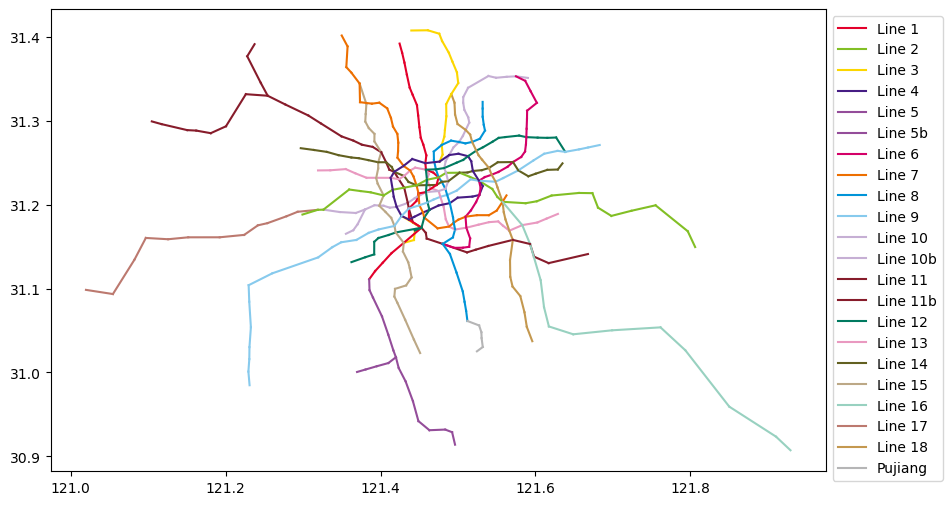

In [12]:
from codes.utils.plot_metro_network import plot_geographical_graph_edge

# plot geographical graph
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_geographical_graph_edge(
    graph,
    x_col = 'x_gcj02', y_col = 'y_gcj02', 
    label_col = 'line_name', color_col = 'line_color',
    ax = ax)

EdgeDataView([(0, 1, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 1101}), (1, 2, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 1178}), (2, 3, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 939}), (3, 4, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 1159}), (5, 6, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 900}), (5, 4, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 1017}), (6, 7, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 1053}), (7, 8, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 1344}), (8, 9, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 953}), (10, 9, {'line_name': 'Line 1', 'line_color': '#78BE20', 'line_cycle': False, 'distance': 1236}), (10, 11, {'line_na